## Hyperspectral Image Segmentation by Convolutional Neural Network 

### standardized spectra at full resolution with spatial dimension included

### training on each image separately

---

In [7]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [8]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [9]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [10]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [11]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [12]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [13]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

In [14]:
def read_labelled_coordinates(kind, scan):
    file = open("../manual_classified_pixels/{0}_coordinates_{1}.txt".format(kind, scan), "r")
    coords = file.readlines()
    file.close()
    coords = np.array([point_from_string(line) for line in coords])
    print("{0}: {1}".format(kind,coords.shape))
    
    return coords

In [15]:
import random

def split_train_test_indices(coords, seed, trrat, kind):
    ind = np.arange(coords.shape[0])
    random.Random(seed).shuffle(ind)
    lim_ind = int(len(ind)*trrat)
    train_ind = ind[:lim_ind]
    test_ind = ind[lim_ind:]
    
    print("{0}: {1} {2}".format(kind, len(train_ind), len(test_ind)))
    
    return train_ind, test_ind

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def CNN_Model(nwaves):
    Inputs_1 = keras.Input(shape=(nwaves, 1), name="spectra")
    Conv1D_1 = layers.Conv1D(16, kernel_size=(50), padding="same", activation="relu")(Inputs_1)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    Dropout_1 = layers.Dropout(0.5)(MaxPool_2)
    Flatten_1 = layers.Flatten()(Dropout_1)

    Inputs_2 = keras.Input(shape=(2,), name="spatial")
    Concat = layers.concatenate([Flatten_1, Inputs_2])
    Dense_1 = layers.Dense(512, activation="relu")(Concat)
    Output = layers.Dense(9, activation="softmax")(Dense_1)

    model = keras.Model(inputs=[Inputs_1, Inputs_2],
                        outputs=[Output],)
    
    return model

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_history(model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.set_title('CNN Model Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.locator_params(nbins=13, axis='x')
    ax1.legend(['train', 'test'], loc='center right')
    ax2.plot(model.history['accuracy'])
    ax2.plot(model.history['val_accuracy'])
    ax2.set_title('CNN Model Accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.locator_params(nbins=12, axis='x')
    ax2.legend(['train', 'test'], loc='center right')
    ax3.plot(model.history['loss'])
    ax3.plot(model.history['val_loss'])
    ax3.set_ylabel('log(loss)')
    ax3.set_xlabel('epoch')
    ax3.locator_params(nbins=13, axis='x')
    ax3.legend(['train', 'test'], loc='center right')
    ax3.set_yscale('log')
    ax4.plot(model.history['accuracy'])
    ax4.plot(model.history['val_accuracy'])
    ax4.set_ylabel('log(accuracy)')
    ax4.set_xlabel('epoch')
    ax4.locator_params(nbins=12, axis='x')
    ax4.legend(['train', 'test'], loc='center right')
    ax4.set_yscale('log')
    plt.show()

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## CNN on veg_00108 (South Facing @ ~2pm)

In [18]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [19]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [20]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [21]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)
print(cube_standard.shape)

(2560000, 848)


#### Reading manually classified set for training and testing

In [22]:
sky_coords = read_labelled_coordinates("1_sky", "108")
clouds_coords = read_labelled_coordinates("2_clouds", "108")
veg_coords = read_labelled_coordinates("3_vegetation", "108")
wtr_coords = read_labelled_coordinates("4_water", "108")
blt_coords = read_labelled_coordinates("5_buildings", "108")
windows_coords = read_labelled_coordinates("6_windows", "108")
rds_coords = read_labelled_coordinates("7_roads", "108")
cars_coords = read_labelled_coordinates("8_cars", "108")
mtl_coords = read_labelled_coordinates("9_metal", "108")

1_sky: (300, 2)
2_clouds: (500, 2)
3_vegetation: (600, 2)
4_water: (50, 2)
5_buildings: (1020, 2)
6_windows: (500, 2)
7_roads: (30, 2)
8_cars: (100, 2)
9_metal: (100, 2)


In [23]:
# create position array and normalize

xy = coords(cube_sub.shape[1], cube_sub.shape[2])
xy = xy/xy.max()

In [24]:
cube_std_3d = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
print(cube_std_3d.shape)
print(xy.shape)

(1600, 1600, 848)
(1600, 1600, 2)


#### split classified pixels into training and testing sets

In [25]:
train_acc = {}
test_acc = {}

In [72]:
#lbl = '50_50'
#trrat = 0.5

#lbl = '20_80'
#trrat = 0.2

lbl = '10_90'
trrat = 0.1

#lbl = '5_95'
#trrat = 0.05

#lbl = '3_97'
#trrat = 0.03

#lbl = '1_99'
#trrat = 0.01

#lbl = '05_995'
#trrat = 0.005

#lbl = '01_999'
#trrat = 0.001

In [73]:
sky_train_ind, sky_test_ind = split_train_test_indices(sky_coords, 0, trrat, "sky")
clouds_train_ind, clouds_test_ind = split_train_test_indices(clouds_coords, 1, trrat, "clouds")
veg_train_ind, veg_test_ind = split_train_test_indices(veg_coords, 2, trrat, "veg")
wtr_train_ind, wtr_test_ind = split_train_test_indices(wtr_coords, 3, trrat, "wtr")
blt_train_ind, blt_test_ind = split_train_test_indices(blt_coords, 4, trrat, "blt")
windows_train_ind, windows_test_ind = split_train_test_indices(windows_coords, 5, trrat, "windows")
rds_train_ind, rds_test_ind = split_train_test_indices(rds_coords, 6, trrat, "rds")
cars_train_ind, cars_test_ind = split_train_test_indices(cars_coords, 7, trrat, "cars")
mtl_train_ind, mtl_test_ind = split_train_test_indices(mtl_coords, 8, trrat, "mtl")

sky: 30 270
clouds: 50 450
veg: 60 540
wtr: 5 45
blt: 102 918
windows: 50 450
rds: 3 27
cars: 10 90
mtl: 10 90


In [74]:
cube_sky_train = cube_std_3d[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_std_3d[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
sky_xy_train = xy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
sky_xy_test = xy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_std_3d[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_std_3d[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
clouds_xy_train = xy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
clouds_xy_test = xy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_std_3d[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_std_3d[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
veg_xy_train = xy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
veg_xy_test = xy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_std_3d[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_std_3d[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
wtr_xy_train = xy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
wtr_xy_test = xy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_std_3d[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_std_3d[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
blt_xy_train = xy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
blt_xy_test = xy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_std_3d[windows_coords[windows_train_ind[:],0], windows_coords[windows_train_ind[:],1],:]
cube_windows_test = cube_std_3d[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
windows_xy_train = xy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
windows_xy_test = xy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_std_3d[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_std_3d[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
rds_xy_train = xy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
rds_xy_test = xy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_std_3d[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_std_3d[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
cars_xy_train = xy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cars_xy_test = xy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_std_3d[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_std_3d[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
mtl_xy_train = xy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
mtl_xy_test = xy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (30, 848) (270, 848)
clouds  (50, 848) (450, 848)
vegetation  (60, 848) (540, 848)
water  (5, 848) (45, 848)
built  (102, 848) (918, 848)
windows  (50, 848) (450, 848)
roads  (3, 848) (27, 848)
cars  (10, 848) (90, 848)
metal  (10, 848) (90, 848)


In [75]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]
xy_train = np.concatenate((sky_xy_train, clouds_xy_train, veg_xy_train, wtr_xy_train, blt_xy_train,
                             windows_xy_train, rds_xy_train, cars_xy_train, mtl_xy_train), axis=0)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]
xy_test = np.concatenate((sky_xy_test, clouds_xy_test, veg_xy_test, wtr_xy_test, blt_xy_test,
                             windows_xy_test, rds_xy_test, cars_xy_test, mtl_xy_test), axis=0)

In [76]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

print(cube_train.shape, cube_train_labels.shape, xy_train.shape)
print(cube_test.shape, cube_test_labels.shape, xy_test.shape)

(320, 848) (320,) (320, 2)
(2880, 848) (2880,) (2880, 2)


### Train CNN

In [77]:
cnn = CNN_Model(cube_std_3d.shape[2])
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [78]:
#keras.utils.plot_model(cnn, show_shapes=True)
#cnn.summary()

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

In [79]:
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels),
                     epochs=200, batch_size=512)

Epoch 1/200
1/1 [==============================] - 0s 375ms/step - loss: 2.2757 - accuracy: 0.1344 - val_loss: 1.7493 - val_accuracy: 0.3187
Epoch 2/200
1/1 [==============================] - 0s 267ms/step - loss: 1.7620 - accuracy: 0.3187 - val_loss: 1.6533 - val_accuracy: 0.4969
Epoch 3/200
1/1 [==============================] - 0s 248ms/step - loss: 1.6565 - accuracy: 0.5312 - val_loss: 1.4244 - val_accuracy: 0.5198
Epoch 4/200
1/1 [==============================] - 0s 258ms/step - loss: 1.4329 - accuracy: 0.5562 - val_loss: 1.2217 - val_accuracy: 0.6698
Epoch 5/200
1/1 [==============================] - 0s 290ms/step - loss: 1.2354 - accuracy: 0.6562 - val_loss: 1.1273 - val_accuracy: 0.6542
Epoch 6/200
1/1 [==============================] - 0s 226ms/step - loss: 1.1333 - accuracy: 0.6594 - val_loss: 1.0077 - val_accuracy: 0.7302
Epoch 7/200
1/1 [==============================] - 0s 240ms/step - loss: 1.0031 - accuracy: 0.7469 - val_loss: 0.9109 - val_accuracy: 0.7059
Epoch 8/200
1

Epoch 59/200
1/1 [==============================] - 0s 248ms/step - loss: 0.2157 - accuracy: 0.9250 - val_loss: 0.3237 - val_accuracy: 0.9021
Epoch 60/200
1/1 [==============================] - 0s 273ms/step - loss: 0.2149 - accuracy: 0.9281 - val_loss: 0.3265 - val_accuracy: 0.9052
Epoch 61/200
1/1 [==============================] - 0s 231ms/step - loss: 0.2112 - accuracy: 0.9344 - val_loss: 0.3180 - val_accuracy: 0.9042
Epoch 62/200
1/1 [==============================] - 0s 225ms/step - loss: 0.2073 - accuracy: 0.9312 - val_loss: 0.3115 - val_accuracy: 0.9049
Epoch 63/200
1/1 [==============================] - 0s 223ms/step - loss: 0.1912 - accuracy: 0.9406 - val_loss: 0.3068 - val_accuracy: 0.9028
Epoch 64/200
1/1 [==============================] - 0s 239ms/step - loss: 0.2018 - accuracy: 0.9312 - val_loss: 0.3015 - val_accuracy: 0.9042
Epoch 65/200
1/1 [==============================] - 0s 334ms/step - loss: 0.1848 - accuracy: 0.9281 - val_loss: 0.3032 - val_accuracy: 0.9104
Epoch 

1/1 [==============================] - 0s 237ms/step - loss: 0.2954 - accuracy: 0.9062 - val_loss: 0.3672 - val_accuracy: 0.8903
Epoch 117/200
1/1 [==============================] - 0s 226ms/step - loss: 0.2803 - accuracy: 0.9219 - val_loss: 0.3665 - val_accuracy: 0.8878
Epoch 118/200
1/1 [==============================] - 0s 251ms/step - loss: 0.2640 - accuracy: 0.9156 - val_loss: 0.3685 - val_accuracy: 0.8865
Epoch 119/200
1/1 [==============================] - 0s 308ms/step - loss: 0.2765 - accuracy: 0.8969 - val_loss: 0.3677 - val_accuracy: 0.8851
Epoch 120/200
1/1 [==============================] - 0s 261ms/step - loss: 0.2729 - accuracy: 0.9156 - val_loss: 0.3644 - val_accuracy: 0.8878
Epoch 121/200
1/1 [==============================] - 0s 259ms/step - loss: 0.2452 - accuracy: 0.9281 - val_loss: 0.3577 - val_accuracy: 0.8969
Epoch 122/200
1/1 [==============================] - 0s 261ms/step - loss: 0.2467 - accuracy: 0.9344 - val_loss: 0.3512 - val_accuracy: 0.8986
Epoch 123/200

1/1 [==============================] - 0s 259ms/step - loss: 0.1648 - accuracy: 0.9375 - val_loss: 0.2824 - val_accuracy: 0.9083
Epoch 174/200
1/1 [==============================] - 0s 253ms/step - loss: 0.1301 - accuracy: 0.9469 - val_loss: 0.2796 - val_accuracy: 0.9104
Epoch 175/200
1/1 [==============================] - 0s 269ms/step - loss: 0.1535 - accuracy: 0.9406 - val_loss: 0.2769 - val_accuracy: 0.9142
Epoch 176/200
1/1 [==============================] - 0s 262ms/step - loss: 0.1473 - accuracy: 0.9594 - val_loss: 0.2753 - val_accuracy: 0.9163
Epoch 177/200
1/1 [==============================] - 0s 235ms/step - loss: 0.1272 - accuracy: 0.9656 - val_loss: 0.2755 - val_accuracy: 0.9135
Epoch 178/200
1/1 [==============================] - 0s 357ms/step - loss: 0.1374 - accuracy: 0.9500 - val_loss: 0.2787 - val_accuracy: 0.9125
Epoch 179/200
1/1 [==============================] - 0s 311ms/step - loss: 0.1346 - accuracy: 0.9531 - val_loss: 0.2772 - val_accuracy: 0.9153
Epoch 180/200

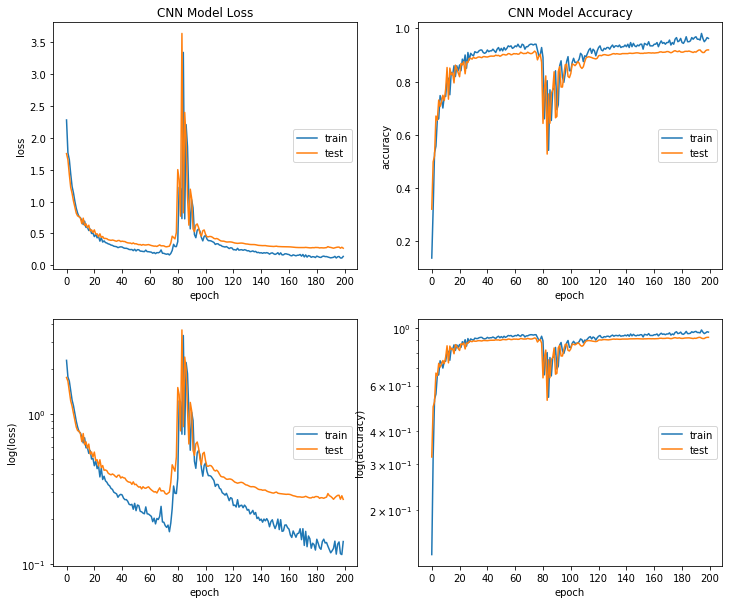

In [80]:
plot_loss_history(CNNmodel)

In [81]:
cnn = CNN_Model(cube_std_3d.shape[2])
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels),
                     epochs=60, batch_size=512)

Epoch 1/60
1/1 [==============================] - 0s 420ms/step - loss: 2.1749 - accuracy: 0.1406 - val_loss: 2.4319 - val_accuracy: 0.3205
Epoch 2/60
1/1 [==============================] - 0s 309ms/step - loss: 2.4214 - accuracy: 0.3281 - val_loss: 1.7014 - val_accuracy: 0.3743
Epoch 3/60
1/1 [==============================] - 0s 259ms/step - loss: 1.7018 - accuracy: 0.3781 - val_loss: 1.6949 - val_accuracy: 0.4931
Epoch 4/60
1/1 [==============================] - 0s 237ms/step - loss: 1.6884 - accuracy: 0.4938 - val_loss: 1.6388 - val_accuracy: 0.4931
Epoch 5/60
1/1 [==============================] - 0s 264ms/step - loss: 1.6408 - accuracy: 0.4969 - val_loss: 1.4881 - val_accuracy: 0.4938
Epoch 6/60
1/1 [==============================] - 0s 276ms/step - loss: 1.4770 - accuracy: 0.5000 - val_loss: 1.2567 - val_accuracy: 0.5437
Epoch 7/60
1/1 [==============================] - 0s 232ms/step - loss: 1.2577 - accuracy: 0.5719 - val_loss: 1.0399 - val_accuracy: 0.7170
Epoch 8/60
1/1 [====

1/1 [==============================] - 0s 359ms/step - loss: 0.2341 - accuracy: 0.9250 - val_loss: 0.3392 - val_accuracy: 0.9003
Epoch 60/60
1/1 [==============================] - 0s 274ms/step - loss: 0.2481 - accuracy: 0.9187 - val_loss: 0.3192 - val_accuracy: 0.9062


In [82]:
# model accuracy on training and testing sets

train_loss, train_acc[trrat] = cnn.evaluate({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels)
test_loss, test_acc[trrat] = cnn.evaluate({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels)

print(train_acc, test_acc)

90/90 [==============================] - 1s 7ms/step - loss: 0.3192 - accuracy: 0.9062
{0.5: 0.9418749809265137, 0.2: 0.9234374761581421, 0.1: 0.934374988079071} {0.5: 0.9212499856948853, 0.2: 0.9144531488418579, 0.1: 0.90625}


### Predict pixel classification on veg_00108

In [83]:
cube_standard_1 = cube_standard.reshape(cube_standard.shape[0], cube_standard.shape[1], 1)
print(cube_standard_1.shape)
xy_2d = xy.reshape((xy.shape[0] * xy.shape[1]), xy.shape[2])
print(xy_2d.shape)

(2560000, 848, 1)
(2560000, 2)


In [84]:
# classify entire binned cube
import time
start_time = time.time()

probCube = cnn.predict({"spectra":cube_standard_1, "spatial":xy_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:09:17


In [85]:
predictCube = probCube.argmax(axis=-1)

In [86]:
predictCube_reshape = predictCube.reshape(cube_sub.shape[1], cube_sub.shape[2])

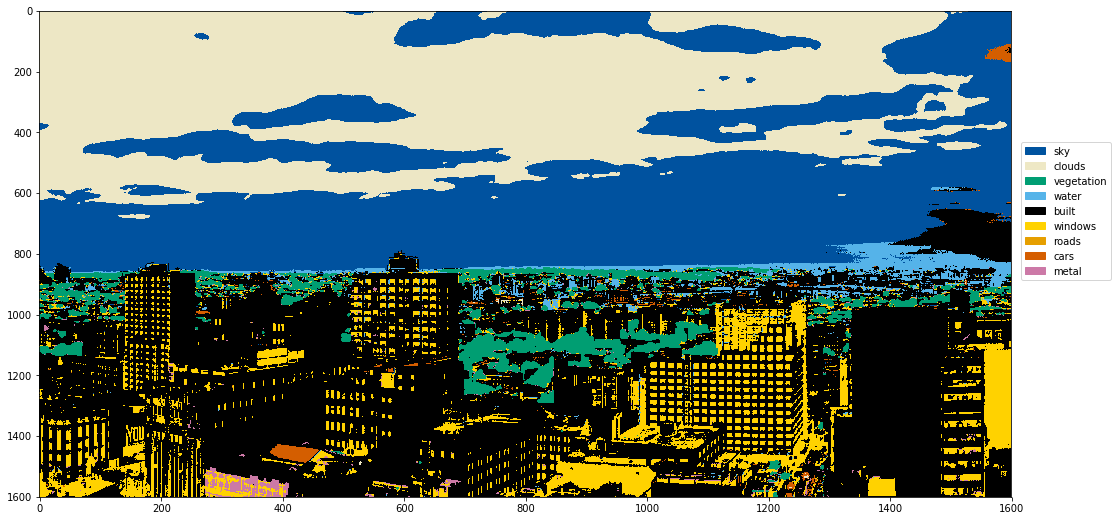

In [87]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_1_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

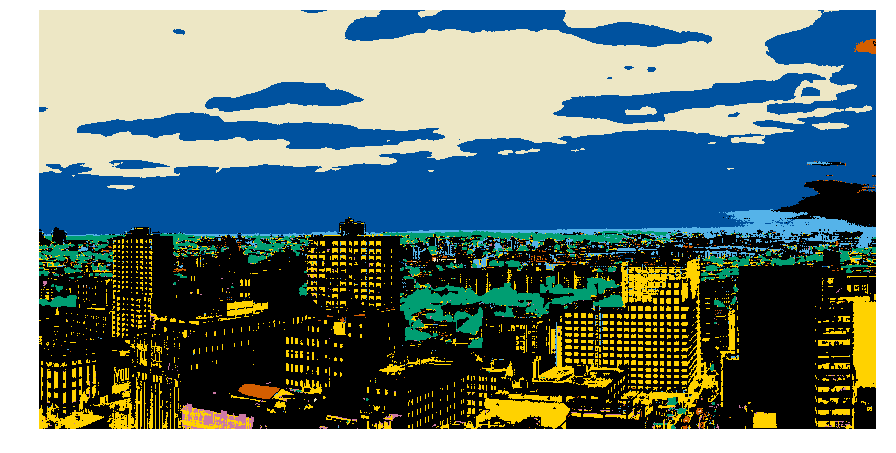

In [88]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
#fig.savefig("./plots/CNN_Model2_spatial_train_108_test_108_predict_map.png", bbox_inches='tight')

In [89]:
#import pickle
#pickle.dump(predictCube_reshape, open("./plots/CNN_Model2_spatial_train_108_test_108_predict_map.pickle", "wb"))

### Evaluation Metrics (veg_00108)

In [90]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [91]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [92]:
print(labels_pred.shape)
print(labels_true.shape)

(2880,)
(2880,)


In [93]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[270   0   0   0   0   0   0   0   0]
 [  1 449   0   0   0   0   0   0   0]
 [  0   0 532   1   7   0   0   0   0]
 [  0   0   0  45   0   0   0   0   0]
 [  0   0   0  19 876  17   0   6   0]
 [  0   0   0   0  46 402   0   1   1]
 [  0   0   0   0  27   0   0   0   0]
 [  0   2   0   5  48   6   0  27   2]
 [  0   0   0   0  70  11   0   0   9]]

Accuracy Score
0.90625

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00       270
     clouds       1.00      1.00      1.00       450
 vegetation       1.00      0.99      0.99       540
      water       0.64      1.00      0.78        45
      built       0.82      0.95      0.88       918
    windows       0.92      0.89      0.91       450
      roads       0.00      0.00      0.00        27
       cars       0.79      0.30      0.44        90
      metal       0.75      0.10      0.18        90

avg / total       0.90      0.91      0.89      2880

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [94]:
f = open("./metrics/CNN_Model2_spatial_train_108_test_108_metrics_{0}_split.txt".format(lbl), "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


___
## Plot Results

In [ ]:
import numpy as np

#train_acc = [train_acc_200, train_acc_100, train_acc_50, train_acc_20, train_acc_10, train_acc_5]
#test_acc =[test_acc_100, test_acc_100, test_acc_50, test_acc_20, test_acc_10, test_acc_5]

plt_train_acc = [0.9574, train_acc[0.5], train_acc[0.2], train_acc[0.1], train_acc[0.05], train_acc[0.03], 
                 train_acc[0.01], train_acc[0.005], train_acc[0.001]]
plt_test_acc =[0.9422, test_acc[0.5], test_acc[0.2], test_acc[0.1], test_acc[0.05], test_acc[0.03],
               test_acc[0.01], test_acc[0.005], test_acc[0.001]]

print(plt_train_acc)
print(plt_test_acc)

In [ ]:
n_groups = 9

avg_prec = np.zeros(n_groups)
avg_recall = np.zeros(n_groups)
avg_f1 = np.zeros(n_groups)
train_size = np.zeros(n_groups)
sky_prec = np.zeros(n_groups)
sky_recall = np.zeros(n_groups)
sky_f1 = np.zeros(n_groups)
sky_train_size = np.zeros(n_groups)
clouds_prec = np.zeros(n_groups)
clouds_recall = np.zeros(n_groups)
clouds_f1 = np.zeros(n_groups)
clouds_train_size = np.zeros(n_groups)
veg_prec = np.zeros(n_groups)
veg_recall = np.zeros(n_groups)
veg_f1 = np.zeros(n_groups)
veg_train_size = np.zeros(n_groups)
wtr_prec = np.zeros(n_groups)
wtr_recall = np.zeros(n_groups)
wtr_f1 = np.zeros(n_groups)
wtr_train_size = np.zeros(n_groups)
blt_prec = np.zeros(n_groups)
blt_recall = np.zeros(n_groups)
blt_f1 = np.zeros(n_groups)
blt_train_size = np.zeros(n_groups)
windows_prec = np.zeros(n_groups)
windows_recall = np.zeros(n_groups)
windows_f1 = np.zeros(n_groups)
windows_train_size = np.zeros(n_groups)
rds_prec = np.zeros(n_groups)
rds_recall = np.zeros(n_groups)
rds_f1 = np.zeros(n_groups)
rds_train_size = np.zeros(n_groups)
cars_prec = np.zeros(n_groups)
cars_recall = np.zeros(n_groups)
cars_f1 = np.zeros(n_groups)
cars_train_size = np.zeros(n_groups)
mtl_prec = np.zeros(n_groups)
mtl_recall = np.zeros(n_groups)
mtl_f1 = np.zeros(n_groups)
mtl_train_size = np.zeros(n_groups)

In [ ]:
def read_prec_recall(file, line):
    Nums = []
    for num in file[line].split():
        try:
            Nums.append(float(num))
        except ValueError:
            pass
    prec = Nums[0]
    recall = Nums[1]
    f1 = Nums[2]
    #size = int(Nums[3]*(tt_ratio/100)/((100-tt_ratio)/100))
    size = Nums[3]
    
    return prec, recall, f1, size

In [ ]:
filename = "./metrics/CNN_Model2_spatial_train_108_test_108_metrics.txt"
f = open(filename, "r")
f1 = f.readlines()
i=0
avg_prec[i], avg_recall[i], avg_f1[i], train_size[i] = read_prec_recall(f1, 27)
sky_prec[i], sky_recall[i], sky_f1[i], sky_train_size[i] = read_prec_recall(f1, 17)
clouds_prec[i], clouds_recall[i], clouds_f1[i], clouds_train_size[i] = read_prec_recall(f1, 18)
veg_prec[i], veg_recall[i], veg_f1[i], veg_train_size[i] = read_prec_recall(f1, 19)
wtr_prec[i], wtr_recall[i], wtr_f1[i], wtr_train_size[i] = read_prec_recall(f1, 20) 
blt_prec[i], blt_recall[i], blt_f1[i], blt_train_size[i] = read_prec_recall(f1, 21)
windows_prec[i], windows_recall[i], windows_f1[i], windows_train_size[i] = read_prec_recall(f1, 22)
rds_prec[i], rds_recall[i], rds_f1[i], rds_train_size[i] = read_prec_recall(f1, 23)
cars_prec[i], cars_recall[i], cars_f1[i], cars_train_size[i] = read_prec_recall(f1, 24)
mtl_prec[i], mtl_recall[i], mtl_f1[i], mtl_train_size[i] = read_prec_recall(f1, 25)
    
f.close()

In [ ]:
train_split = ['80_20', '50_50', '20_80', '10_90', '5_95', '3_97', '1_99', '05_995', '01_999']
#tr_splits = [80, 50, 20, 10, 5, 3, 1, 0.5, 0.1]

#i=0
#for split in train_split:
for i in range(1,n_groups):
    filename = "./metrics/CNN_Model2_spatial_train_108_test_108_metrics_{0}_split.txt".format(train_split[i])
    f = open(filename, "r")
    f1 = f.readlines()

    avg_prec[i], avg_recall[i], avg_f1[i], train_size[i] = read_prec_recall(f1, 27)
    sky_prec[i], sky_recall[i], sky_f1[i], sky_train_size[i] = read_prec_recall(f1, 17)
    clouds_prec[i], clouds_recall[i], clouds_f1[i], clouds_train_size[i] = read_prec_recall(f1, 18)
    veg_prec[i], veg_recall[i], veg_f1[i], veg_train_size[i] = read_prec_recall(f1, 19)
    wtr_prec[i], wtr_recall[i], wtr_f1[i], wtr_train_size[i] = read_prec_recall(f1, 20) 
    blt_prec[i], blt_recall[i], blt_f1[i], blt_train_size[i] = read_prec_recall(f1, 21)
    windows_prec[i], windows_recall[i], windows_f1[i], windows_train_size[i] = read_prec_recall(f1, 22)
    rds_prec[i], rds_recall[i], rds_f1[i], rds_train_size[i] = read_prec_recall(f1, 23)
    cars_prec[i], cars_recall[i], cars_f1[i], cars_train_size[i] = read_prec_recall(f1, 24)
    mtl_prec[i], mtl_recall[i], mtl_f1[i], mtl_train_size[i] = read_prec_recall(f1, 25)
    
    f.close()
    #i += 1

In [ ]:
train_size = 3200 - train_size
sky_train_size = sky_coords.shape[0] - sky_train_size
clouds_train_size = clouds_coords.shape[0] - clouds_train_size
veg_train_size = veg_coords.shape[0] - veg_train_size
wtr_train_size = wtr_coords.shape[0] - wtr_train_size
blt_train_size = blt_coords.shape[0] - blt_train_size
windows_train_size = windows_coords.shape[0] - windows_train_size
rds_train_size = rds_coords.shape[0] - rds_train_size
cars_train_size = cars_coords.shape[0] - cars_train_size
mtl_train_size = mtl_coords.shape[0] - mtl_train_size

In [ ]:
print(train_size)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

#train_size = [2560, 1600, 640, 320, 159]

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,5))

ax1.plot(train_size, plt_train_acc, '-o', color='b', lw=3, label='train')
ax1.plot(train_size, plt_test_acc, '-o', color='g', lw=3, label='test')
ax1.set_title("Accuracy", fontsize=20)
ax1.set_xlabel("training instances")
ax1.set_ylabel("accuracy")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, facecolor='white')
ax1.set_xscale('log', basex=2)
ax1.xaxis.set_major_formatter(ScalarFormatter())
#ax1.set_xticks(train_size)
ax1.set_xlim(2800,8)
ax1.set_ylim(0.55,0.99)

ax2.plot(train_size, avg_prec, '-o', color='b', lw=3, label='mP')
ax2.plot(train_size, avg_recall, '-o', color='y', lw=3, label='mR')
ax2.plot(train_size, avg_f1, '-o', color='r', lw=3, label='mF1')
ax2.set_title("Mean Precision, Recall, and F1-Score", fontsize=20)
ax2.set_xlabel("training instances")
ax2.set_ylabel("metric")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, facecolor='white')
ax2.set_xscale('log', basex=2)
ax2.xaxis.set_major_formatter(ScalarFormatter())
#ax2.set_xticks(train_size)
ax2.set_xlim(2800,8)
ax2.set_ylim(0.55,0.99)

plt.show
#fig.savefig("./plots/CNN_spatial_train_108_train_test_ratio_overall_metrics_extend.png", bbox_inches='tight', dpi=300

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(25,18))
ax1.plot(sky_train_size[:-1], sky_prec[:-1], '-o', color='b', lw=3, label='Precision')
ax1.plot(sky_train_size[:-1], sky_recall[:-1], '-o', color='y', lw=3, label='Recall')
ax1.plot(sky_train_size[:-1], sky_f1[:-1], '-o', color='r', lw=3, label='F1 Score')
ax1.set(title="Sky")
ax1.set_xscale('log', basex=2)
ax1.xaxis.set_major_formatter(ScalarFormatter())
#ax1.set_xticks(sky_train_size[:-1])
ax1.set_xticks([1,2,8,32,128,512])
ax1.set_ylim(-0.1,1.1)
ax1.set_xlim(0.8,1000)
ax1.set_ylabel("metric")
ax1.invert_xaxis()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, facecolor='white', loc='lower left')

ax2.plot(clouds_train_size, clouds_prec, '-o', color='b', lw=3)
ax2.plot(clouds_train_size, clouds_recall, '-o', color='y', lw=3)
ax2.plot(clouds_train_size, clouds_f1, '-o', color='r', lw=3)
ax2.set(title="Clouds")
ax2.set_xscale('log', basex=2)
ax2.xaxis.set_major_formatter(ScalarFormatter())
#ax2.set_xticks(clouds_train_size)
ax2.set_xticks([1,2,8,32,128,512])
ax2.set_ylim(-0.1,1.1)
ax2.set_xlim(0.8,1000)
ax2.invert_xaxis()
ax2.legend(handles, labels, facecolor='white', loc='lower left')

ax3.plot(veg_train_size, veg_prec, '-o', color='b', lw=3)
ax3.plot(veg_train_size, veg_recall, '-o', color='y', lw=3)
ax3.plot(veg_train_size, veg_f1, '-o', color='r', lw=3)
ax3.set(title="Vegetation")
ax3.set_xscale('log', basex=2)
ax3.xaxis.set_major_formatter(ScalarFormatter())
#ax3.set_xticks(veg_train_size)
ax3.set_xticks([1,2,8,32,128,512])
ax3.set_ylim(-0.1,1.1)
ax3.set_xlim(0.8,1000)
ax3.invert_xaxis()
ax3.legend(handles, labels, facecolor='white', loc='lower left')

ax4.plot(wtr_train_size[:-3], wtr_prec[:-3], '-o', color='b', lw=3)
ax4.plot(wtr_train_size[:-3], wtr_recall[:-3], '-o', color='y', lw=3)
ax4.plot(wtr_train_size[:-3], wtr_f1[:-3], '-o', color='r', lw=3)
ax4.set(title="Water")
ax4.set_xscale('log', basex=2)
ax4.xaxis.set_major_formatter(ScalarFormatter())
#ax4.set_xticks(wtr_train_size[:-3])
ax4.set_xticks([1,2,8,32,128,512])
ax4.set_ylim(-0.1,1.1)
ax4.set_xlim(0.8,1000)
ax4.set_ylabel("metric")
ax4.invert_xaxis()
ax4.legend(handles, labels, facecolor='white', loc='lower left')

ax5.plot(blt_train_size, blt_prec, '-o', color='b', lw=3)
ax5.plot(blt_train_size, blt_recall, '-o', color='y', lw=3)
ax5.plot(blt_train_size, blt_f1, '-o', color='r', lw=3)
ax5.set(title="Built")
ax5.set_xscale('log', basex=2)
ax5.xaxis.set_major_formatter(ScalarFormatter())
#ax5.set_xticks(blt_train_size)
ax5.set_xticks([1,2,8,32,128,512])
ax5.set_xlim(0.8,1000)
ax5.set_ylim(-0.1,1.1)
ax5.invert_xaxis()
ax5.legend(handles, labels, facecolor='white', loc='lower left')

ax6.plot(windows_train_size, windows_prec, '-o', color='b', lw=3, label='Precision')
ax6.plot(windows_train_size, windows_recall, '-o', color='y', lw=3, label='Recall')
ax6.plot(windows_train_size, windows_f1, '-o', color='r', lw=3, label='F1 Score')
ax6.set(title="Windows")
ax6.set_xscale('log', basex=2)
ax6.xaxis.set_major_formatter(ScalarFormatter())
#ax6.set_xticks(windows_train_size)
ax6.set_xticks([1,2,8,32,128,512])
ax6.set_ylim(-0.1,1.1)
ax6.set_xlim(0.8,1000)
ax6.invert_xaxis()
ax6.legend(handles, labels, facecolor='white', loc='lower left')

ax7.plot(rds_train_size[:-4], rds_prec[:-4], '-o', color='b', lw=3)
ax7.plot(rds_train_size[:-4], rds_recall[:-4], '-o', color='y', lw=3)
ax7.plot(rds_train_size[:-4], rds_f1[:-4], '-o', color='r', lw=3)
ax7.set(title="Roads")
ax7.set_xscale('log', basex=2)
ax7.xaxis.set_major_formatter(ScalarFormatter())
#ax7.set_xticks(rds_train_size[:-4])
ax7.set_xticks([1,2,8,32,128,512])
ax7.set_ylim(-0.1,1.1)
ax7.set_xlim(0.8,1000)
ax7.set_xlabel("training instances")
ax7.set_ylabel("metric")
ax7.invert_xaxis()
ax7.legend(handles, labels, facecolor='white', loc='lower left')

ax8.plot(cars_train_size[:-2], cars_prec[:-2], '-o', color='b', lw=3)
ax8.plot(cars_train_size[:-2], cars_recall[:-2], '-o', color='y', lw=3)
ax8.plot(cars_train_size[:-2], cars_f1[:-2], '-o', color='r', lw=3)
ax8.set(title="Cars")
ax8.set_xscale('log', basex=2)
ax8.xaxis.set_major_formatter(ScalarFormatter())
#ax8.set_xticks(cars_train_size[:-2])
ax8.set_xticks([1,2,8,32,128,512])
ax8.set_ylim(-0.1,1.1)
ax8.set_xlim(0.8,1000)
ax8.set_xlabel("training instances")
ax8.invert_xaxis()
ax8.legend(handles, labels, facecolor='white', loc='lower left')

ax9.plot(mtl_train_size[:-2], mtl_prec[:-2], '-o', color='b', lw=3)
ax9.plot(mtl_train_size[:-2], mtl_recall[:-2], '-o', color='y', lw=3)
ax9.plot(mtl_train_size[:-2], mtl_f1[:-2], '-o', color='r', lw=3)
ax9.set(title="Metal")
ax9.set_xscale('log', basex=2)
ax9.xaxis.set_major_formatter(ScalarFormatter())
#ax9.set_xticks(mtl_train_size[:-2])
ax9.set_xticks([1,2,8,32,128,512])
ax9.set_ylim(-0.1,1.1)
ax9.set_xlim(0.8,1000)
ax9.set_xlabel("training instances")
ax9.invert_xaxis()
ax9.legend(handles, labels, facecolor='white', loc='lower left')

#handles, labels = ax6.get_legend_handles_labels()
#ax6.legend(handles, labels, loc='center right', borderaxespad=-10.0)

plt.show()
#fig.savefig("./plots/CNN_spatial_train_108_train_test_ratio_3_By_Class_Prec_Recall_extend.png",
#           bbox_inches='tight', dpi=300)